In [121]:
#загрузка необходимых библиотек
import requests
from lxml import html
import pandas as pd
import time
from math import sqrt
import numpy as np
from tqdm import tqdm
import re
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder

## 1. Парсинг сайта

In [2]:
urls = ['https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_to=7800000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=7800100&price_to=9000000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=9000001&price_to=10200000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=10201000&price_to=11500000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=11550000&price_to=12990000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=13000000&price_to=14500000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=14510000&price_to=16500000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=16510000&price_to=18900000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=18910000&price_to=22400000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=22410000&price_to=26700000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=26710000&price_to=34000000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=34000001&price_to=51500000&page=',
'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=51500001&price_to=110000000&page=']
odd = 'https://sob.ru/prodazha-kvartir-moskva?total_room_count[]=1&total_room_count[]=2&total_room_count[]=3&total_room_count[]=4&price_from=110000001&page='
#по 30 страниц в urls, 13 страниц в odd (максимум для показа на сайте - 30 стр. по 35 объявлений на каждой)

In [3]:
price = []
metro = []
rooms = []
sum_square = []
kit_square = []
floor = []
all_floors = []
balcony = []
lift = []
conditions = []
materials = []
year = []
coords = []

In [4]:
def parse_links(ws):
    req = requests.get(ws)
    tree = html.fromstring(req.content)
    links = tree.xpath('//a/@href')
    for link in links:
        if (link.startswith('//sob.ru/prodazha-kvartir') and link[-1].isdigit() and 'card' in link) or (link.startswith('//zhk') and link[-1].isdigit()):
            apart.append(link)

In [5]:
def parse_page(lnk):
    req = requests.get(lnk)
    tree = html.fromstring(req.content)
    pr_data = tree.xpath('//p[@class="text-price"]//text()')
    price.append(int(pr_data[0][:-1].replace(' ', '')))
    r_data = tree.xpath('//div[@class="adv-page-title"]//text()')
    rooms.append(int(r_data[0].split()[1][0]))
    m_data = [value for value in tree.xpath('//p[@class="subway-link"]//text()') if '\n' not in value and value.strip() != '']
    metro.append(m_data[0])
    all_data = tree.xpath('//div[@class="flex-four-equals"]//text()')
    all_data = [value for value in all_data if '\n' not in value and value.strip() != '' and value != '2']
    sum_square.append(all_data[3].replace(' ', '')[:-1].replace(',', '.'))
    kit_square.append(all_data[9].replace(' ', '')[:-1].replace(',', '.'))
    floor.append(int(all_data[1].split(' / ')[0]))
    all_floors.append(int(all_data[1].split(' / ')[1]))
    balcony.append(all_data[11])
    lift.append(all_data[13])
    conditions.append(all_data[21])
    materials.append(all_data[23])
    year.append(all_data[25])
    c_data = tree.xpath('/html/head/script/text()')
    crd = [i for i in c_data if 'coords:' in i][0]
    crd = crd[(crd.index('[') + 1):crd.index(']')]
    coords.append(crd)

In [6]:
k = 1
for url in urls:
    apart = []
    print(f'Starting {k}/{len(urls)+1} iteration')
    for i in range(1, 31):
        parse_links(url + str(i))
    print(f'Found {len(apart)} links for url')
    for elem in tqdm(apart):
        try:
            parse_page('https:' + elem)
        except:
            sleep(60)
            continue
    print('Finished.')
    k+=1

Starting 1/14 iteration
Found 1056 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1056/1056 [06:24<00:00,  2.84it/s]


Finished.
Starting 2/14 iteration
Found 1060 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1060/1060 [06:32<00:00,  3.06it/s]


Finished.
Starting 3/14 iteration
Found 1058 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1058/1058 [06:05<00:00,  3.90it/s]


Finished.
Starting 4/14 iteration
Found 1059 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:41<00:00,  3.81it/s]


Finished.
Starting 5/14 iteration
Found 1066 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1066/1066 [05:18<00:00,  2.70it/s]


Finished.
Starting 6/14 iteration
Found 1061 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1061/1061 [06:12<00:00,  4.42it/s]


Finished.
Starting 7/14 iteration
Found 1058 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1058/1058 [05:43<00:00,  3.38it/s]


Finished.
Starting 8/14 iteration
Found 1063 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1063/1063 [05:24<00:00,  3.03it/s]


Finished.
Starting 9/14 iteration
Found 1062 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1062/1062 [06:20<00:00,  3.02it/s]


Finished.
Starting 10/14 iteration
Found 1062 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1062/1062 [06:27<00:00,  2.64it/s]


Finished.
Starting 11/14 iteration
Found 1071 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1071/1071 [06:30<00:00,  2.90it/s]


Finished.
Starting 12/14 iteration
Found 1079 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1079/1079 [06:31<00:00,  3.03it/s]


Finished.
Starting 13/14 iteration
Found 1068 links for url


100%|██████████████████████████████████████████████████████████████████████████████| 1068/1068 [06:23<00:00,  2.68it/s]


Finished.


In [7]:
print(f'Starting 14/{len(urls)+1} iteration')
apart = []
for i in range(1, 14):
    parse_links(odd + str(i))
print(f'Found {len(apart)} links for url')
for elem in tqdm(apart):
    try:
        parse_page('https:' + elem)
    except:
        sleep(60)
        continue
print('Finished.')

Starting 14/14 iteration
Found 461 links for url


100%|████████████████████████████████████████████████████████████████████████████████| 461/461 [02:55<00:00,  2.63it/s]


Finished.


## 2. Обработка данных

Изначально имеем следующие поля: 
1.	Станция метро Underground
2.	Количество комнат Rooms 
3.	Общая площадь Sum_Square
4.	Площадь кухни Kit_Square
5.	Этаж квартиры Floor
6.	Этажность здания All Floors
7.	Наличие балкона/лоджии Balcony
8.	Наличие лифта Lift
9.	 Состояние квартиры Conditions
10.	 Тип дома Materials
11.	 Год постройки дома Year
12.	 Цена Price
13.	 Координаты местоположения квартиры Coords

In [122]:
df = pd.DataFrame(list(zip(metro, rooms, sum_square, kit_square, floor,
                           all_floors, balcony, lift, conditions, materials,year, price, coords)),
                    columns =['Underground', 'Rooms', 'Sum_Square', 'Kit_Square',
                              'Floor', 'All_Floors', 'Balcony', 'Lift', 'Conditions', 'Materials', 'Year', 'Price','Coords'])
df

,Underground,Rooms,Sum_Square,Kit_Square,Floor,All_Floors,Balcony,Lift,Conditions,Materials,Year,Price,Coords
0,Белокаменная (МЦК),1,32.8,неуказан,3,9,не указано,не указано,хорошее состояние,блочный,1969,7800000,"55.82002,37.714617"
1,Автозаводская,2,44,14/14,2,4,балкон,нет лифта,дизайнерский ремонт,кирпичный,1936,7350000,"55.703773,37.640066"
2,Нижегородская,2,37.4,12.20-8.50,2,22,лоджия,лифт пассажирский и лифт грузовой,не указано,монолитный,2023,7694058,"55.727435,37.73544"
3,Нижегородская,1,37,15,5,31,лоджия,лифт пассажирский и лифт грузовой,не указано,монолитный,2023,7649639,"55.727435,37.73544"
4,Нижегородская,1,35.4,14,6,31,лоджия,лифт пассажирский и лифт грузовой,не указано,монолитный,2023,7608699,"55.727435,37.73544"
5,Нижегородская,1,35.8,14,2,31,лоджия,лифт пассажирский и лифт грузовой,не указано,монолитный,2023,7658031,"55.727435,37.73544"
6,Бабушкинская,1,31.8,неуказан,4,5,балкон,нет лифта,хорошее состояние,кирпичный,1963,7700000,"55.869359,37.671876"
7,Перово,1,33,неуказан,3,9,нет,есть лифт,без отделки,панельный,1972,7500000,"55.740208,37.820861"
8,Алма-Атинская,3,56.8,неуказан,7,9,балкон,лифт пассажирский,среднее состояние,кирпичный,1968,7600000,"55.635559,37.795565"
9,Нижегородская,1,37.7,15,2,31,лоджия,лифт пассажирский и лифт грузовой,не указано,монолитный,2023,7755775,"55.727435,37.73544"


In [123]:
df = df.drop_duplicates()

In [124]:
for col in df.columns:
    print(df[col].unique())

['Белокаменная  (МЦК)' 'Автозаводская ' 'Нижегородская ' 'Бабушкинская '
 'Перово ' 'Алма-Атинская ' 'Ботанический сад ' 'ЗИЛ  (МЦК)'
 'Красный Строитель  (МЦД-2)' 'Бульвар Рокоссовского ' 'Пятницкое шоссе '
 'Некрасовка ' 'Коломенская ' 'Лухмановская ' 'Фили ' 'Селигерская '
 'Братиславская ' 'Черкизовская ' 'Бибирево ' 'Алтуфьево ' 'Ховрино '
 'Ленинградская  (МЦД-2)' 'Окружная ' 'Спартак ' 'Новохохловская  (МЦД-2)'
 'Молодежная ' 'Текстильщики ' 'Авиамоторная ' 'Водный стадион ' 'Окская '
 'Владыкино ' 'Улица Скобелевская ' 'Мичуринский проспект ' 'Нагатинская '
 'Преображенская площадь ' 'Бутырская ' 'Домодедовская ' 'Люблино '
 'Славянский бульвар ' 'Речной вокзал ' 'Полежаевская ' 'Добрынинская '
 'Калитники  (МЦД-2)' 'Аннино ' 'Царицыно ' 'Чертановская ' 'Кузьминки '
 'Новокосино ' 'Выхино ' 'Щелковская ' 'Коммунарка ' 'Медведково '
 'Лесопарковая ' 'Стахановская ' 'ВДНХ ' 'Первомайская ' 'Измайловская '
 'Нахабино  (МЦД-2)' 'Комсомольская ' 'Отрадное ' 'Тушинская ' 'Борисово '


 ' есть лифт' ' лифт пассажирский' ' лифт грузовой']
[' хорошее состояние' ' дизайнерский ремонт' 'не указано' ' без отделки'
 ' среднее состояние' ' первичная отделка' ' отличное состояние'
 ' евроремонт' ' требуется ремонт' ' требуется капитальный ремонт']
[' блочный' ' кирпичный' ' монолитный' ' панельный' ' монолитно-кирпичный'
 'не указано' ' сталинский' ' деревянный' ' железобетон']
[' 1969' ' 1936' ' 2023' ' 1963' ' 1972' ' 1968' ' 2022' ' 1976' ' 1974'
 ' 1961' ' 2010' ' 2019' ' 1991' ' 1970' ' 2006' ' 1982' 'не указано'
 ' 2021' ' 2020' ' 1965' ' 1962' ' 2017' ' 1978' ' 1926' ' 1973' ' 1971'
 ' 1984' ' 1997' ' 2014' ' 2003' ' 1966' ' 2005' ' 2011' ' 2013' ' 2018'
 ' 1977' ' 1987' ' 1959' ' 1981' ' 1958' ' 1964' ' 1990' ' 1989' ' 2008'
 ' 2002' ' 1967' ' 1985' ' 1960' ' 2016' ' 2007' ' 1975' ' 1999' ' 2001'
 ' 2012' ' 1983' ' 1995' ' 2000' ' 1980' ' 1992' ' 1993' ' 1988' ' 1979'
 ' 2015' ' 1938' ' 1998' ' 1994' ' 1986' ' 1956' ' 1996' ' 1957' ' 1924'
 ' 1955' ' 1954' ' 1949' ' 

In [125]:
del df['Kit_Square']
del df['Underground']
del df['Conditions']
df.head()

,Rooms,Sum_Square,Floor,All_Floors,Balcony,Lift,Materials,Year,Price,Coords
0,1,32.8,3,9,не указано,не указано,блочный,1969,7800000,"55.82002,37.714617"
1,2,44,2,4,балкон,нет лифта,кирпичный,1936,7350000,"55.703773,37.640066"
2,2,37.4,2,22,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7694058,"55.727435,37.73544"
3,1,37,5,31,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7649639,"55.727435,37.73544"
4,1,35.4,6,31,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7608699,"55.727435,37.73544"


In [126]:
df = df[np.logical_and(df['Materials'] != 'не указано', df['Year'] != 'не указано')]

In [127]:
null_coords = (55.755831, 37.617673) #координаты центра города
df['Coords'] = [haversine((float(i) for i in x.split(',')), null_coords) for x in df['Coords']]
df.head()

,Rooms,Sum_Square,Floor,All_Floors,Balcony,Lift,Materials,Year,Price,Coords
0,1,32.8,3,9,не указано,не указано,блочный,1969,7800000,9.363717
1,2,44,2,4,балкон,нет лифта,кирпичный,1936,7350000,5.955981
2,2,37.4,2,22,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7694058,8.019342
3,1,37,5,31,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7649639,8.019342
4,1,35.4,6,31,лоджия,лифт пассажирский и лифт грузовой,монолитный,2023,7608699,8.019342


Заменим параметр с координатами на параметр удаленности от центра города

In [128]:
df = df.rename(columns = {'Coords': 'FromCentre'})

Закодируем признак наличия балкона

In [129]:
df.loc[np.logical_and(df['Balcony'] != 'не указано', df['Balcony'] != ' нет'), 'Balcony'] = 1
df.loc[np.logical_or(df['Balcony'] == 'не указано', df['Balcony'] == ' нет'), 'Balcony'] = 0
df.head()

,Rooms,Sum_Square,Floor,All_Floors,Balcony,Lift,Materials,Year,Price,FromCentre
0,1,32.8,3,9,0,не указано,блочный,1969,7800000,9.363717
1,2,44,2,4,1,нет лифта,кирпичный,1936,7350000,5.955981
2,2,37.4,2,22,1,лифт пассажирский и лифт грузовой,монолитный,2023,7694058,8.019342
3,1,37,5,31,1,лифт пассажирский и лифт грузовой,монолитный,2023,7649639,8.019342
4,1,35.4,6,31,1,лифт пассажирский и лифт грузовой,монолитный,2023,7608699,8.019342


Т.к. неуказанных о наличии лифта довольно много, заполним их. В большинстве случаев в доме, в котором меньше 5 этажей - нет лифта, а больше - лифт есть. Закодируем данные о наличии лифта

In [130]:
df.loc[np.logical_and(df['Lift'] != 'не указано', df['Lift'] != ' нет лифта'), 'Lift'] = 1
df.loc[np.logical_and(np.logical_or(df['Lift'] == 'не указано', df['Lift'] == ' нет лифта'), df['All_Floors'] > 5), 'Lift'] = 1
df.loc[np.logical_and(np.logical_or(df['Lift'] == 'не указано', df['Lift'] == ' нет лифта'), df['All_Floors'] <= 5), 'Lift'] = 0
df.head()

,Rooms,Sum_Square,Floor,All_Floors,Balcony,Lift,Materials,Year,Price,FromCentre
0,1,32.8,3,9,0,1,блочный,1969,7800000,9.363717
1,2,44,2,4,1,0,кирпичный,1936,7350000,5.955981
2,2,37.4,2,22,1,1,монолитный,2023,7694058,8.019342
3,1,37,5,31,1,1,монолитный,2023,7649639,8.019342
4,1,35.4,6,31,1,1,монолитный,2023,7608699,8.019342


In [131]:
df.dtypes

Rooms           int64
Sum_Square     object
Floor           int64
All_Floors      int64
Balcony         int64
Lift            int64
Materials      object
Year           object
Price           int64
FromCentre    float64
dtype: object

In [132]:
df.Sum_Square = df.Sum_Square.astype('float')
df.Year = df.Year.astype('int')

Для кодируемого категориального признака о типе здания Materials создаются N новых признаков, где N — число категорий. Каждый i-й новый признак — бинарный характеристический признак i-й категории.

In [133]:
df = pd.get_dummies(df, columns=['Materials'])
df.head()

,Rooms,Sum_Square,Floor,All_Floors,Balcony,Lift,Year,Price,FromCentre,Materials_ блочный,Materials_ деревянный,Materials_ железобетон,Materials_ кирпичный,Materials_ монолитно-кирпичный,Materials_ монолитный,Materials_ панельный,Materials_ сталинский
0,1,32.8,3,9,0,1,1969,7800000,9.363717,1,0,0,0,0,0,0,0
1,2,44.0,2,4,1,0,1936,7350000,5.955981,0,0,0,1,0,0,0,0
2,2,37.4,2,22,1,1,2023,7694058,8.019342,0,0,0,0,0,1,0,0
3,1,37.0,5,31,1,1,2023,7649639,8.019342,0,0,0,0,0,1,0,0
4,1,35.4,6,31,1,1,2023,7608699,8.019342,0,0,0,0,0,1,0,0


In [136]:
len(df)

13010

## 3. Описательный анализ данных

In [134]:
df.dtypes

Rooms                               int64
Sum_Square                        float64
Floor                               int64
All_Floors                          int64
Balcony                             int64
Lift                                int64
Year                                int32
Price                               int64
FromCentre                        float64
Materials_ блочный                  uint8
Materials_ деревянный               uint8
Materials_ железобетон              uint8
Materials_ кирпичный                uint8
Materials_ монолитно-кирпичный      uint8
Materials_ монолитный               uint8
Materials_ панельный                uint8
Materials_ сталинский               uint8
dtype: object

In [74]:
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize']=(10,6)

In [75]:
df.Price.describe()

count    1.301000e+04
mean     2.771230e+07
std      4.094204e+07
min      3.090000e+06
25%      1.070145e+07
50%      1.610000e+07
75%      2.747835e+07
max      1.080838e+09
Name: Price, dtype: float64

Корреляционная матрица, которая позволяет увидеть зависимость признаков друг от друга. Самая высокая корреляция наблюдается между ценой и площадью квартиры, а также ценой и количеством комнат в квартире. Это довольно логично, поскольку это главные параметры, определяющие цену. Самой высокой отрицательной корреляцией является корреляция между ценой и удаленностью от центра, т.к. чем ближе квартиры к центру Москвы, тем они в основном дороже

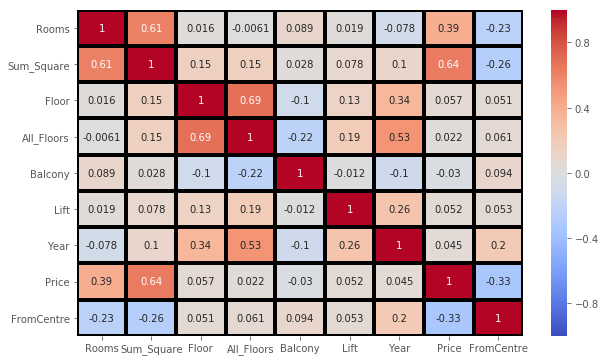

In [79]:
corrMatrix = df.drop(['Materials_ блочный', 'Materials_ деревянный', 
                     'Materials_ железобетон', 'Materials_ кирпичный', 
                     'Materials_ монолитно-кирпичный', 'Materials_ монолитный', 
                     'Materials_ панельный', 'Materials_ сталинский'], axis=1).corr()
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

Зависимость цены от даты постройки здания

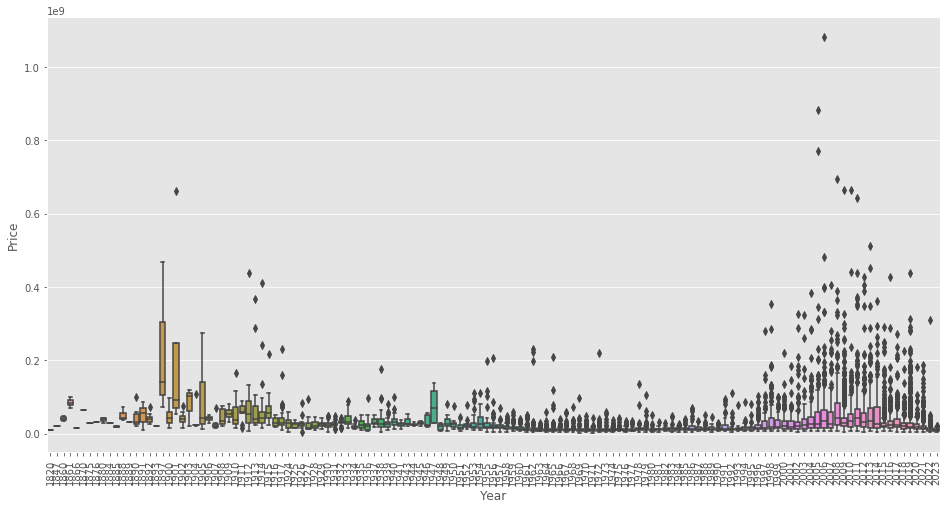

In [110]:
var = 'Year'
data = pd.concat([df['Price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="Price", data=df)
plt.xticks(rotation=90);

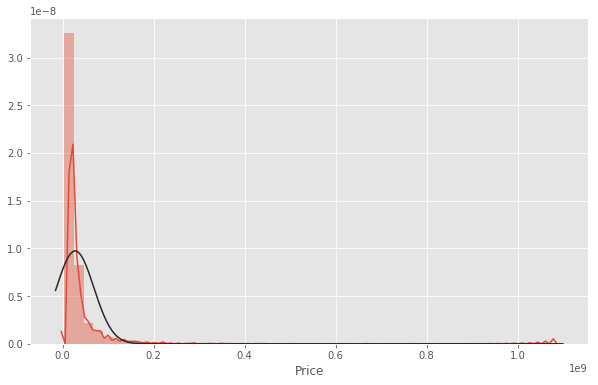

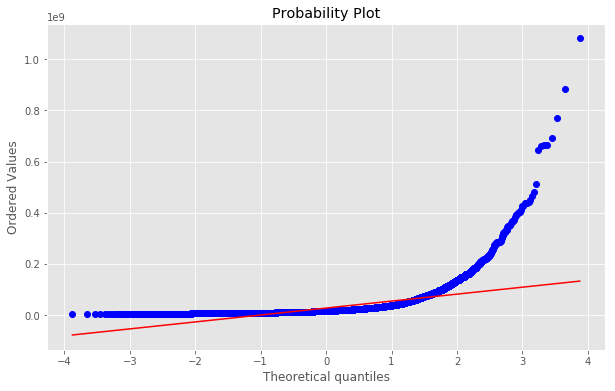

In [114]:
sns.distplot(df['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Price'], plot=plt)

Распределение сильно смещено влево, поэтому прологарифмируем цены

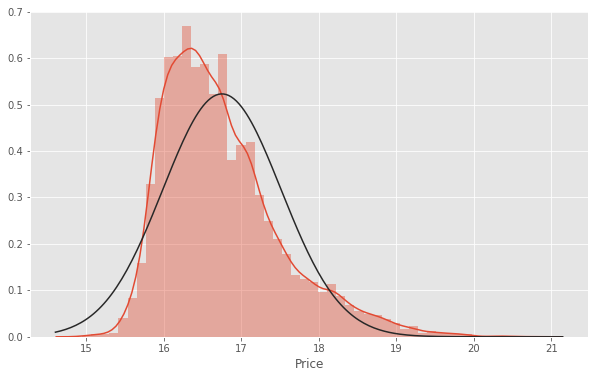

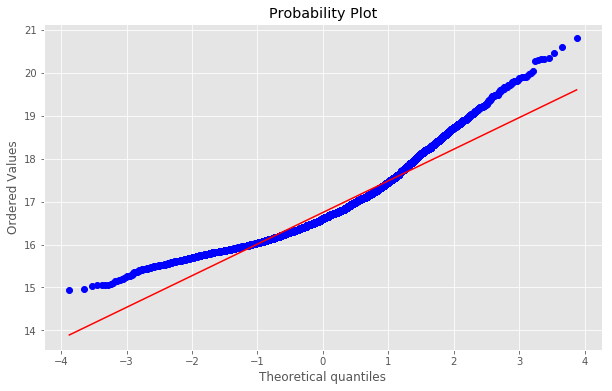

In [116]:
sns.distplot(np.log(df['Price']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df['Price']), plot=plt)

Распределение логарифмированных цен

 Skew is : 1.0929915125070517


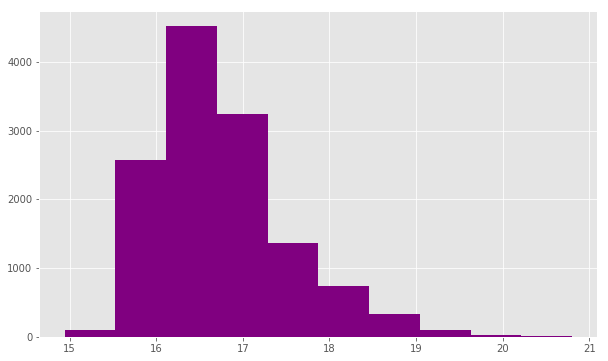

In [142]:
target = np.log(df.Price)
print(" Skew is :", target.skew())
plt.hist(target, color="purple");

Распределение цен в зависимости от количества комнат. Чем больше в квартире комнат, тем выше цена.

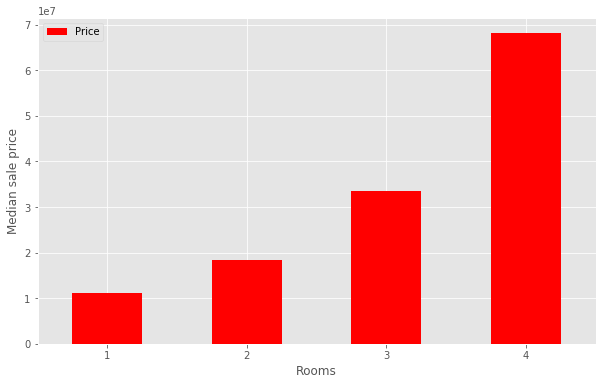

In [119]:
pivot = df.pivot_table(index = 'Rooms', values='Price',)
pivot.plot(kind='bar',color = "r");
plt.xlabel("Rooms")
plt.ylabel("Median sale price")
plt.xticks(rotation=0);

Диаграмма рассеяния для отображения взаимосвязи между площадью квартиры и ее ценой

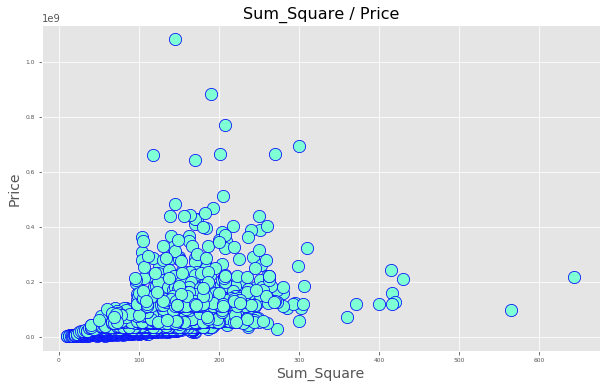

In [120]:
y_var = 'Price'
i = df.columns
plot1 = sns.scatterplot(i[1], y_var, data = df, color = 'aquamarine', edgecolor = 'b', s = 150)
plt.title('{} / Price'.format(i[1]), fontsize = 16)
plt.xlabel('{}'.format(i[1]), fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()

## 4. Обучение модели

In [96]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

### Линейная регрессия

In [97]:
y = np.log(df.Price)
X = df.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2)
lr = linear_model.LinearRegression()
model= lr.fit(X_train, y_train)
y_prd = lr.predict(X_test)
print_evaluate(y_prd, y_test)
model.score(X_train, y_train)

MAE: 0.2434787385894292
MSE: 0.11420843875100808
RMSE: 0.3379473905077654
R2 Square 0.7523044649723398


0.8046163885849451

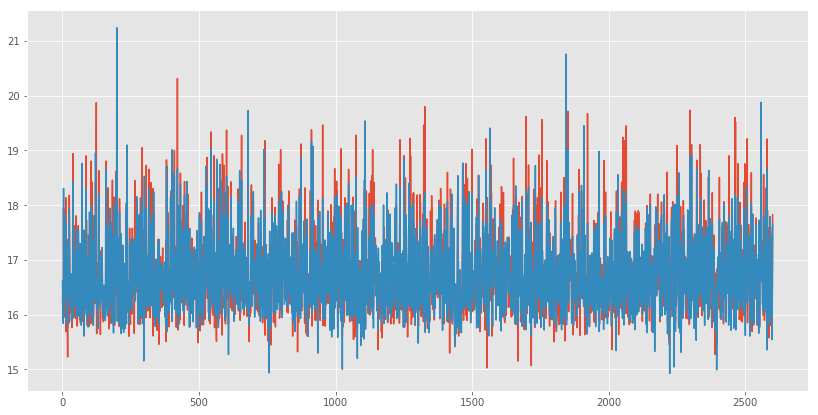

0.9735195943610163

In [151]:
y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(14,7))
plt.plot(y_test,label ='Test')
plt.plot(y_prd, label = 'predict')
plt.show()


reg.score(X_train, y_train)

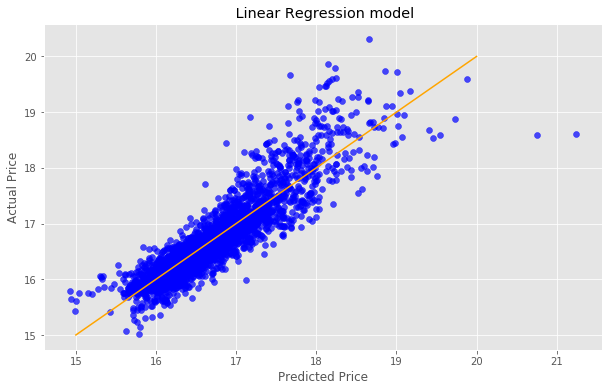

In [149]:
actual_values = y_test

plt.scatter(y_prd, actual_values, alpha=.7, color='b') # alpha shows overlapping data

plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title(" Linear Regression model")
plt.plot(list(range(15, 21)),list(range(15, 21)), c = 'orange')
plt.show()

### GradientBoostingRegressor

In [100]:
reg = GradientBoostingRegressor(random_state=42,
                                n_estimators = 1000,
                                max_depth = 5,
                                min_samples_leaf = 6,
                                min_samples_split = 10)
                                
reg.fit(X_train, y_train)
pred_reg = reg.predict(X_test)

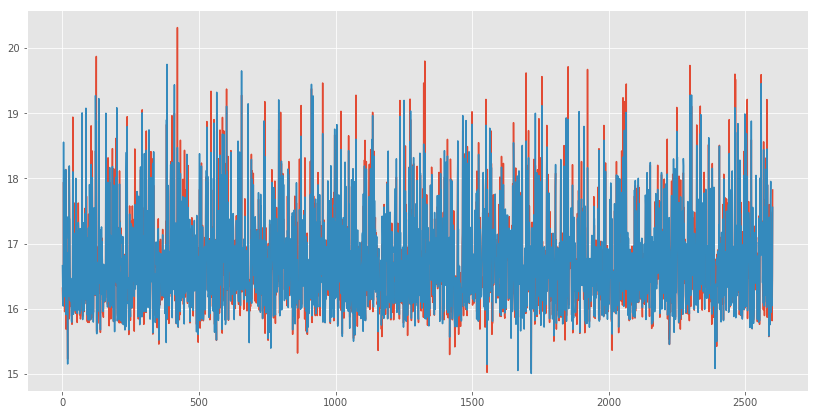

MAE: 0.1508987806033739
MSE: 0.05137988961661554
RMSE: 0.22667132508682156
R2 Square 0.9042863937687988


0.9735195943610163

In [101]:
y_test = y_test.reset_index(drop=True)
plt.figure(figsize=(14,7))
plt.plot(y_test,label ='Test')
plt.plot(pred_reg, label = 'predict')
plt.show()

print_evaluate(pred_reg, y_test)
reg.score(X_train, y_train)

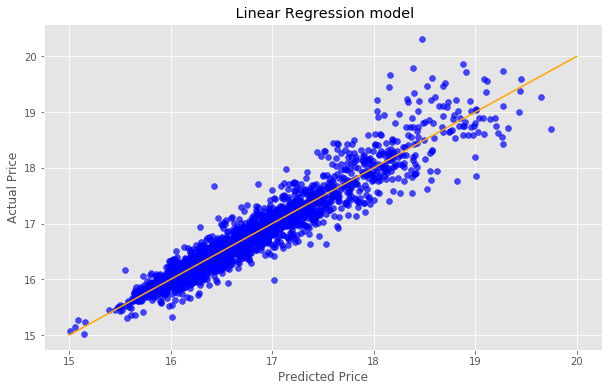

In [150]:
actual_values = y_test

plt.scatter(pred_reg, actual_values, alpha=.7, color='b') # alpha shows overlapping data

plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title(" Linear Regression model")
plt.plot(list(range(15, 21)),list(range(15, 21)), c = 'orange')
plt.show()

### XGBRegressor

In [107]:
xgb = XGBRegressor(learning_rate=0.01,
                       n_estimators=1000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
xgb.fit(X_train, y_train, verbose=False)
pred_xgb = xgb.predict(X_test)

[03:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


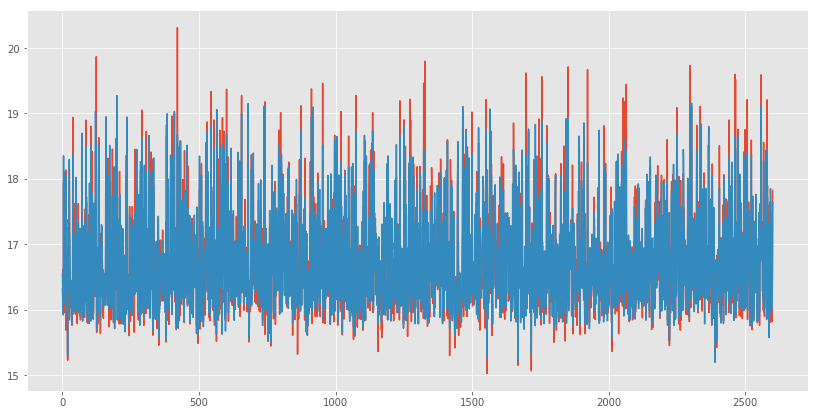

MAE: 0.17727988363082473
MSE: 0.06376191913610185
RMSE: 0.2525112257625428
R2 Square 0.8744176063660625


0.8998244231996358

In [108]:
plt.figure(figsize=(14,7))
plt.plot(y_test,label ='Test')
plt.plot(pred_xgb, label = 'predict')
plt.show()

print_evaluate(pred_xgb, y_test)
xgb.score(X_train, y_train)

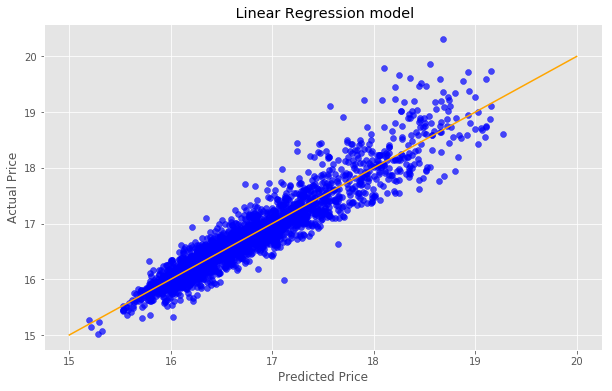

In [152]:
actual_values = y_test

plt.scatter(pred_xgb, actual_values, alpha=.7, color='b') # alpha shows overlapping data

plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title(" Linear Regression model")
plt.plot(list(range(15, 21)),list(range(15, 21)), c = 'orange')
plt.show()

# Выводы
В рамках проведенной работы были собраны данные о продаваемых квартирах. У каждой квартиры были определены следующие параметры:
1.	Количество комнат Rooms 
2.	Общая площадь Sum_Square
3.	Этаж квартиры Floor
4.	Этажность здания All Floors
5.	Наличие балкона/лоджии Balcony
6.	Наличие лифта Lift
7.	 Тип дома Materials
8.	 Год постройки дома Year
9.	 Цена Price
10.	 Удаленность квартиры от центра города FromCentre

Собранные данные были приведены к необходимому для анализа виду. 

Были построены графики, которые помогли понять природу и количество данных и зависимость данных друг от друга.


К имеющимся данным была применена линейная регрессия для предсказания цены автомобиля по имеющимся параметрам, были применены методы XGBoost и GradientBoostingRegressor. Лучше всех показала себя модель GradientBoostingRegressor, score: 0.9735195943610163, MAE: 0.1508987806033739, MSE: 0.05137988961661554, RMSE: 0.22667132508682156, R2 Square 0.9042863937687988. 